In [1]:
import torch
import os
import shutil
import numpy as np
import xml.etree.ElementTree as ET
from PIL import Image
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
%pip install ultralytics
from ultralytics import YOLO



/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Note: you may need to restart the kernel to use updated packages.


In [2]:
# =============================================
# 1. Dataset Selection & Preprocessing
# =============================================

def check_cuda():
    if torch.cuda.is_available():
        print(f"CUDA is available. GPU: {torch.cuda.get_device_name(0)}")
        print("CUDA version:", torch.version.cuda)
    else:
        print("CUDA is not available. Using CPU")

check_cuda()

# Install dependencies (commented out for script, would run in notebook)
# !pip install roboflow ultralytics albumentations wandb

# Paths to VOC directories
base_dir = '/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val'
images_dir = os.path.join(base_dir, 'JPEGImages')
annotations_dir = os.path.join(base_dir, 'Annotations')
sets_dir = os.path.join(base_dir, 'ImageSets/Main')

# Setup directory structure with test split added
split_base = '/kaggle/working/yolo_dataset'
os.makedirs(split_base, exist_ok=True)

# Create directories for splits (70% train, 20% val, 10% test)
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(split_base, 'images', split), exist_ok=True)
    os.makedirs(os.path.join(split_base, 'labels', split), exist_ok=True)

# Function to read predefined splits
def get_files_from_split(file_path):
    with open(file_path, 'r') as f:
        files = [x.strip().split()[0] for x in f.readlines() if not x.startswith('#')]
    return files

# Get all files and split into 70-20-10
trainval_files = get_files_from_split(os.path.join(sets_dir, 'trainval.txt'))
np.random.shuffle(trainval_files)

train_split = int(len(trainval_files) * 0.7)
val_split = train_split + int(len(trainval_files) * 0.2)

train_files = trainval_files[:train_split]
val_files = trainval_files[train_split:val_split]
test_files = trainval_files[val_split:]



CUDA is available. GPU: Tesla T4
CUDA version: 12.1


In [3]:
# =============================================
# 2. Data Augmentation Setup
# =============================================

def get_augmentations(train=True):
    if train:
        return A.Compose([
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.Rotate(limit=30, p=0.5),
            A.GaussianBlur(p=0.1),
            # A.Cutout(num_holes=8, max_h_size=32, max_w_size=32, p=0.5),
            A.CoarseDropout(max_holes=8, max_height=32, max_width=32, 

                           min_holes=1, min_height=8, min_width=8, 

                           fill_value=0, p=0.5),  # Replaces Cutout
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))
    else:
        return A.Compose([ToTensorV2()])



In [4]:
# =============================================
# 3. Annotation Conversion with Augmentation Support
# =============================================

class_mapping = {
    'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3,
    'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7,
    'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11,
    'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15,
    'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19
}

def convert_and_augment(annotation_path, image_path, output_dir, split):
    # Read image and annotation
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    
    # Get image dimensions
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)
    
    # Prepare bounding boxes and labels
    bboxes = []
    class_labels = []
    
    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls_name = obj.find('name').text
        if int(difficult) == 1 or cls_name not in class_mapping:
            continue
            
        xmlbox = obj.find('bndbox')
        xmin = float(xmlbox.find('xmin').text)
        ymin = float(xmlbox.find('ymin').text)
        xmax = float(xmlbox.find('xmax').text)
        ymax = float(xmlbox.find('ymax').text)
        
        # Convert to YOLO format (normalized)
        x_center = ((xmin + xmax) / 2) / w
        y_center = ((ymin + ymax) / 2) / h
        bbox_width = (xmax - xmin) / w
        bbox_height = (ymax - ymin) / h
        
        bboxes.append([x_center, y_center, bbox_width, bbox_height])
        class_labels.append(class_mapping[cls_name])
    
    # Apply augmentations only to training data
    if split == 'train':
        transform = get_augmentations(train=True)
        transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)
        image = transformed['image']
        bboxes = transformed['bboxes']
        class_labels = transformed['class_labels']
    else:
        transform = get_augmentations(train=False)
        transformed = transform(image=image)
        image = transformed['image']
    
    # Save augmented image
    img_filename = os.path.basename(image_path)
    img_output_path = os.path.join(output_dir, 'images', split, img_filename)
    cv2.imwrite(img_output_path, image.numpy().transpose(1, 2, 0)[..., ::-1])
    
    # Save updated annotations
    txt_filename = os.path.splitext(img_filename)[0] + '.txt'
    txt_output_path = os.path.join(output_dir, 'labels', split, txt_filename)
    
    with open(txt_output_path, 'w') as f:
        for cls_id, bbox in zip(class_labels, bboxes):
            f.write(f"{cls_id} {' '.join(map(str, bbox))}\n")



In [5]:
# =============================================
# 4. Process Dataset with Augmentation
# =============================================

def process_dataset(files, split):
    for f in files:
        img_path = os.path.join(images_dir, f + '.jpg')
        ann_path = os.path.join(annotations_dir, f + '.xml')
        convert_and_augment(ann_path, img_path, split_base, split)

# Process all splits
process_dataset(train_files, 'train')
process_dataset(val_files, 'val')
process_dataset(test_files, 'test')

print(f"Dataset splits created:")
print(f"- Training: {len(train_files)} images")
print(f"- Validation: {len(val_files)} images")
print(f"- Testing: {len(test_files)} images")



/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/functional.py:211: RuntimeWarning: invalid value encountered in divide
  visibility_ratio = 1 - (intersection_area / box_areas[i])


Dataset splits created:
- Training: 8077 images
- Validation: 2308 images
- Testing: 1155 images


In [6]:
dataset_config = {
    "train": "/kaggle/working/yolo_dataset/images/train",
    "val": "/kaggle/working/yolo_dataset/images/val",
    "test": "/kaggle/working/yolo_dataset/images/test",
    
    "nc": 20,
    "names": [
        "aeroplane", "bicycle", "bird", "boat", "bottle",
        "bus", "car", "cat", "chair", "cow",
        "diningtable", "dog", "horse", "motorbike", "person",
        "pottedplant", "sheep", "sofa", "train", "tvmonitor"
    ],
}

import yaml
# Save new dataset configuration to a YAML file
yaml_path = "/kaggle/working/data_custom.yaml"
with open(yaml_path, "w") as f:
    yaml.dump(dataset_config, f)


In [6]:
# =============================================
# 5. Model Training with Augmented Data
# =============================================


# Initialize YOLOv8 model
model = YOLO('yolov8n.pt')

# Train with augmented data
model.train(
    data=yaml_path,
    epochs=50,
    imgsz=640,
    batch=16,
    augment=True,  # Enable built-in augmentation
    project='yolov8_augmentation_study',
    name='augmented_run',
    exist_ok=True
)



Ultralytics 8.3.100 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/data_custom.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=yolov8_augmentation_study, name=augmented_run, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_label

train: Scanning /kaggle/working/yolo_dataset/labels/train.cache... 8077 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8077/8077 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/yolo_dataset/labels/val.cache... 2308 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2308/2308 [00:00<?, ?it/s]


Plotting labels to yolov8_augmentation_study/augmented_run/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to yolov8_augmentation_study/augmented_run
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       2.1G      1.425      3.071      1.564         75        640: 100%|██████████| 505/505 [01:27<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:13<00:00,  5.41it/s]


                   all       2308       5558       0.66      0.571      0.615      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.25G      1.434      2.504      1.587         81        640: 100%|██████████| 505/505 [01:24<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.71it/s]


                   all       2308       5558      0.628      0.549      0.574      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.25G      1.423       2.45      1.589        102        640: 100%|██████████| 505/505 [01:23<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.68it/s]


                   all       2308       5558      0.624      0.516      0.562      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.25G      1.417      2.392      1.584         77        640: 100%|██████████| 505/505 [01:23<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:13<00:00,  5.58it/s]


                   all       2308       5558      0.582      0.517      0.516      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.26G       1.38      2.301      1.562         91        640: 100%|██████████| 505/505 [01:22<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.73it/s]


                   all       2308       5558      0.621      0.547      0.568      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.26G      1.359      2.252      1.547         88        640: 100%|██████████| 505/505 [01:21<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.73it/s]


                   all       2308       5558      0.673      0.531      0.582      0.379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.26G      1.346       2.19      1.536        116        640: 100%|██████████| 505/505 [01:22<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.62it/s]


                   all       2308       5558      0.661      0.553        0.6      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.26G      1.341      2.155      1.535        119        640: 100%|██████████| 505/505 [01:23<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.77it/s]


                   all       2308       5558      0.647       0.56      0.609      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.26G      1.317      2.099      1.518         99        640: 100%|██████████| 505/505 [01:22<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.75it/s]


                   all       2308       5558      0.684      0.579      0.632      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.26G      1.307      2.066      1.511         70        640: 100%|██████████| 505/505 [01:23<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.80it/s]


                   all       2308       5558      0.717      0.556      0.631      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.26G      1.293      2.033        1.5         83        640: 100%|██████████| 505/505 [01:22<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.77it/s]


                   all       2308       5558      0.693      0.596      0.644      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.26G      1.288      1.996      1.493        113        640: 100%|██████████| 505/505 [01:22<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.76it/s]


                   all       2308       5558       0.72      0.587      0.657      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.26G      1.269      1.956      1.485        104        640: 100%|██████████| 505/505 [01:22<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.81it/s]


                   all       2308       5558      0.691      0.603      0.649      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.26G      1.261      1.934      1.481        100        640: 100%|██████████| 505/505 [01:21<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.63it/s]


                   all       2308       5558      0.715      0.598      0.663      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.26G      1.256      1.916      1.476        128        640: 100%|██████████| 505/505 [01:21<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.78it/s]


                   all       2308       5558      0.704      0.602       0.66      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.26G      1.252      1.892      1.469        102        640: 100%|██████████| 505/505 [01:21<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.69it/s]


                   all       2308       5558      0.738      0.601      0.672      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.26G      1.241      1.865      1.462         74        640: 100%|██████████| 505/505 [01:21<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.73it/s]


                   all       2308       5558      0.725      0.616      0.677      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.26G      1.243      1.851      1.462         66        640: 100%|██████████| 505/505 [01:22<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.67it/s]


                   all       2308       5558      0.706      0.622       0.67      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.26G      1.226      1.817      1.452         67        640: 100%|██████████| 505/505 [01:21<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.64it/s]


                   all       2308       5558      0.725      0.617      0.682      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.26G      1.223      1.817      1.452        105        640: 100%|██████████| 505/505 [01:22<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.79it/s]


                   all       2308       5558      0.736      0.615      0.678      0.473

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.26G      1.214      1.785      1.444         66        640: 100%|██████████| 505/505 [01:20<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:13<00:00,  5.61it/s]


                   all       2308       5558      0.741      0.615      0.676      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.26G      1.212      1.764      1.442        132        640: 100%|██████████| 505/505 [01:22<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.87it/s]


                   all       2308       5558      0.761      0.613      0.694      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.26G      1.202      1.749       1.43        118        640: 100%|██████████| 505/505 [01:21<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.67it/s]


                   all       2308       5558      0.747      0.638      0.699      0.481

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.26G      1.196      1.732      1.424         96        640: 100%|██████████| 505/505 [01:21<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.81it/s]


                   all       2308       5558      0.715      0.634      0.684      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.26G      1.182      1.714      1.416         69        640: 100%|██████████| 505/505 [01:21<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.86it/s]


                   all       2308       5558      0.749      0.627      0.691      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.26G      1.179      1.697      1.415         74        640: 100%|██████████| 505/505 [01:21<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.94it/s]


                   all       2308       5558      0.756      0.641        0.7      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.26G      1.176       1.67      1.414        107        640: 100%|██████████| 505/505 [01:20<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.90it/s]


                   all       2308       5558      0.762      0.629      0.705       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.26G       1.17      1.662      1.408         78        640: 100%|██████████| 505/505 [01:21<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.98it/s]


                   all       2308       5558      0.756      0.638      0.706      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.26G      1.161       1.65      1.403        103        640: 100%|██████████| 505/505 [01:21<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  6.02it/s]


                   all       2308       5558      0.755      0.642      0.712      0.497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.26G      1.161      1.638      1.398         70        640: 100%|██████████| 505/505 [01:21<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.95it/s]


                   all       2308       5558      0.749      0.645      0.709      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.26G      1.149      1.612      1.388        101        640: 100%|██████████| 505/505 [01:22<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  6.00it/s]


                   all       2308       5558      0.777      0.635      0.715      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.26G      1.143      1.593      1.388         97        640: 100%|██████████| 505/505 [01:21<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.93it/s]


                   all       2308       5558      0.768      0.641      0.708      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.26G      1.142      1.588      1.385        107        640: 100%|██████████| 505/505 [01:22<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.89it/s]


                   all       2308       5558      0.775      0.642      0.713      0.497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.26G      1.134      1.585      1.379        110        640: 100%|██████████| 505/505 [01:21<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.99it/s]


                   all       2308       5558      0.751      0.665      0.716      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.26G      1.121      1.558       1.37        102        640: 100%|██████████| 505/505 [01:21<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.84it/s]


                   all       2308       5558      0.789      0.639      0.711      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.26G      1.126      1.545      1.369         98        640: 100%|██████████| 505/505 [01:21<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.85it/s]


                   all       2308       5558      0.767      0.659      0.718      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.26G      1.114      1.529      1.363         99        640: 100%|██████████| 505/505 [01:22<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.85it/s]


                   all       2308       5558      0.767      0.657      0.722      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.26G      1.114      1.509      1.357         78        640: 100%|██████████| 505/505 [01:21<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.94it/s]


                   all       2308       5558      0.765      0.664       0.72      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.26G      1.113      1.506      1.362         87        640: 100%|██████████| 505/505 [01:21<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.87it/s]


                   all       2308       5558      0.768      0.663      0.723      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.26G      1.096      1.485      1.352        116        640: 100%|██████████| 505/505 [01:20<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.98it/s]


                   all       2308       5558      0.774      0.662      0.721      0.512
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.26G      1.137      1.328      1.382         40        640: 100%|██████████| 505/505 [01:19<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  6.04it/s]


                   all       2308       5558      0.778      0.648      0.713      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.26G      1.102      1.256      1.361         59        640: 100%|██████████| 505/505 [01:18<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  6.07it/s]


                   all       2308       5558       0.77      0.659      0.715      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.26G       1.09      1.226      1.351         42        640: 100%|██████████| 505/505 [01:19<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.80it/s]


                   all       2308       5558      0.786      0.648      0.719      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.26G      1.077      1.214      1.345         54        640: 100%|██████████| 505/505 [01:19<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:11<00:00,  6.10it/s]


                   all       2308       5558      0.786      0.651      0.719      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.26G      1.074      1.199       1.34         45        640: 100%|██████████| 505/505 [01:18<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.98it/s]


                   all       2308       5558        0.8      0.646      0.721      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.26G      1.061      1.179      1.326         43        640: 100%|██████████| 505/505 [01:18<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  6.03it/s]


                   all       2308       5558      0.766      0.665       0.72      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.26G      1.052      1.164      1.319         37        640: 100%|██████████| 505/505 [01:19<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  6.01it/s]


                   all       2308       5558      0.785      0.657      0.723      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.26G       1.04      1.146      1.309         47        640: 100%|██████████| 505/505 [01:18<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:11<00:00,  6.15it/s]


                   all       2308       5558      0.781      0.654      0.721      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.26G      1.037      1.141      1.311         60        640: 100%|██████████| 505/505 [01:19<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:11<00:00,  6.12it/s]


                   all       2308       5558      0.782      0.657      0.722      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.26G      1.035      1.133      1.309         32        640: 100%|██████████| 505/505 [01:19<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:11<00:00,  6.11it/s]


                   all       2308       5558      0.784      0.657      0.722      0.517

50 epochs completed in 1.314 hours.
Optimizer stripped from yolov8_augmentation_study/augmented_run/weights/last.pt, 6.2MB
Optimizer stripped from yolov8_augmentation_study/augmented_run/weights/best.pt, 6.2MB

Validating yolov8_augmentation_study/augmented_run/weights/best.pt...
Ultralytics 8.3.100 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,009,548 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:20<00:00,  3.55it/s]


                   all       2308       5558      0.764       0.67      0.734      0.536
             aeroplane        139        183      0.843       0.82      0.864      0.623
               bicycle        107        137      0.838      0.759      0.812      0.623
                  bird        151        205       0.74      0.737      0.759      0.515
                  boat        105        155      0.688      0.561      0.661      0.451
                bottle        129        272      0.774       0.48      0.614      0.419
                   bus        101        123      0.861      0.805       0.86      0.744
                   car        208        370      0.807        0.7      0.796       0.57
                   cat        251        296      0.807      0.764      0.813       0.61
                 chair        232        490      0.673      0.516      0.591      0.403
                   cow         53        109      0.718      0.725      0.768      0.567
           diningtabl

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 4.9ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to yolov8_augmentation_study/augmented_run


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ad66e626c20>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043

In [7]:
# =============================================
# 6. Evaluation (to be extended with metrics)
# =============================================

# Load best model
model = YOLO(os.path.join('yolov8_augmentation_study', 'augmented_run', 'weights', 'best.pt'))

# Evaluate on test set
metrics = model.val(
    # data=os.path.join(split_base, 'data.yaml'),
    data='/kaggle/working/data_custom.yaml',
    split='test'
)

# Print key metrics
print("\nEvaluation Metrics:")
print(f"mAP@0.5: {metrics.box.map50:.4f}")
print(f"mAP@0.5:0.95: {metrics.box.map:.4f}")
print(f"Precision: {metrics.box.mp:.4f}")
print(f"Recall: {metrics.box.mr:.4f}")

Ultralytics 8.3.100 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,009,548 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /kaggle/working/yolo_dataset/labels/test... 2876 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2876/2876 [00:02<00:00, 1180.62it/s]


val: New cache created: /kaggle/working/yolo_dataset/labels/test.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [00:19<00:00,  9.34it/s]


                   all       2876       6909      0.826      0.725      0.797      0.589
             aeroplane        162        219      0.931      0.805      0.898      0.661
               bicycle        130        165      0.833      0.783      0.852      0.659
                  bird        201        287        0.8      0.724      0.794      0.543
                  boat        135        221       0.75      0.597      0.677      0.444
                bottle        188        309      0.809      0.536      0.658      0.463
                   bus        120        176      0.923      0.795      0.858      0.729
                   car        289        525      0.854      0.722      0.818      0.597
                   cat        272        303      0.871      0.848      0.885      0.674
                 chair        270        558      0.737      0.525      0.629      0.426
                   cow         70        127      0.811      0.779      0.815      0.607
           diningtabl

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/val10

Evaluation Metrics:
mAP@0.5: 0.7968
mAP@0.5:0.95: 0.5895
Precision: 0.8259
Recall: 0.7246


# Model Inference

In [8]:
from ultralytics import YOLO

# Load the model
model_path='/kaggle/working/yolov8_augmentation_study/augmented_run/weights/best.pt'
model = YOLO(model_path)

In [9]:
# Perform inference
results = model.predict('/kaggle/input/pascal-voc-2012-dataset/VOC2012_test/VOC2012_test/JPEGImages/2008_000001.jpg')
detections = results[0].boxes
# Iterate over detected objects and print their class and confidence score
for i, det in enumerate(detections):
    # Access attributes from each detection
    conf = det.conf.item()  # Convert tensor to float
    class_id = int(det.cls)  # Class ID
    class_name = results[0].names[class_id]  # Corrected access to class names

    #print(f"Detection {i+1}: {class_name} ({conf:.2f})")

# Initialize a dictionary to hold counts of detected objects by class
class_counts = {}

for det in detections:
    class_id = int(det.cls)  # Extract class ID
    class_name = results[0].names[class_id]
    # Increment count for the detected class
    if class_name in class_counts:
        class_counts[class_name] += 1
    else:
        class_counts[class_name] = 1


image 1/1 /kaggle/input/pascal-voc-2012-dataset/VOC2012_test/VOC2012_test/JPEGImages/2008_000001.jpg: 640x448 1 motorbike, 34.3ms
Speed: 1.8ms preprocess, 34.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


In [10]:
import cv2
from PIL import Image

# Load the image
image_path = results[0].path
image = cv2.imread(image_path)

# Set font for the annotations
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.5
font_color = (255, 255, 255)  # White color for visibility
font_thickness = 2

# Iterate over detected objects and draw bounding box and annotations
for i, det in enumerate(detections):
    # Extract bounding box coordinates, confidence, and class_id
    x1, y1, x2, y2 = map(int, det.xyxy[0].cpu().numpy())
    conf = det.conf.item()  # Convert tensor to float
    class_id = int(det.cls)  # Convert tensor to int
    class_name = results[0].names[class_id]

    # Draw bounding box
    box_color = (255, 0, 0)  # Blue color for the box
    cv2.rectangle(image, (x1, y1), (x2, y2), box_color, 2)

    # Annotation text for class name and confidence
    #label = f"{class_name} {conf:.2f}"
    label = f"{class_name} {conf:.2f} (Count: {class_counts[class_name]})"

    # Determine text size (width and height)
    text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]
    text_width = text_size[0]
    text_height = text_size[1]
    
    # Calculate position for the text (inside the top-left corner of the bounding box)
    text_x = x1 + 5  # 5 pixels from the left edge of the bounding box
    text_y = max(y1 + text_height + 5, y1 + 5)  # 5 pixels above the top edge of the bounding box

    # Insert the label text inside the bounding box
    cv2.putText(image, label, (text_x, text_y), font, font_scale, font_color, font_thickness)

# Convert the BGR image to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

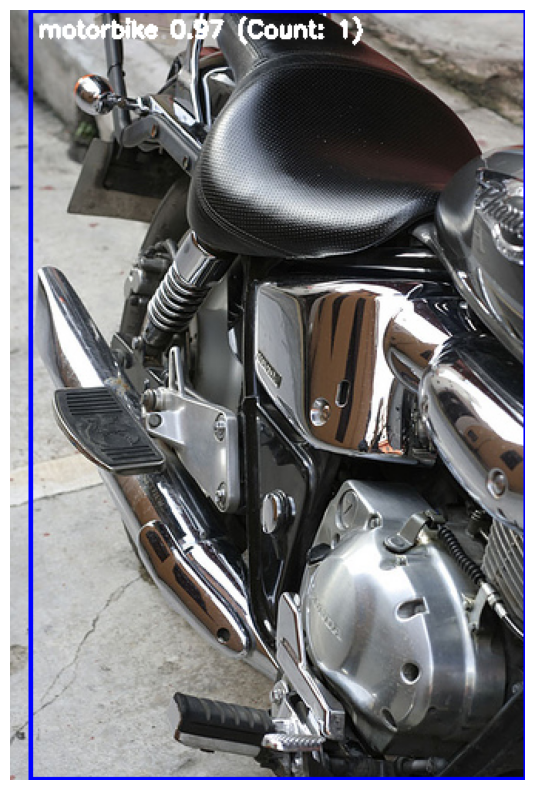

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()